In [3]:
#import necessary frameworks.
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from surprise.model_selection import train_test_split
from surprise import KNNWithMeans,KNNWithZScore, SVD, SlopeOne, SVDpp, NMF, NormalPredictor, KNNBaseline, KNNBasic,BaselineOnly, CoClustering
from surprise import Reader,Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
import math


In [4]:
# Load Electronics ratings data.
# Add column names.
e_commerce_data = pd.read_csv('ratings_Electronics.csv')
e_commerce_data.columns = ['userID','productID','rating','timestamp']

In [5]:
# Let's see how the data is present.
e_commerce_data.drop(columns=['timestamp'],inplace=True)
e_commerce_data.head()

,userID,productID,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [6]:
# Let's check shape of the data
print(f"Numeber of rows:{e_commerce_data.shape[0]} and number of cols:{e_commerce_data.shape[1]}")

Numeber of rows:7824481 and number of cols:3


In [7]:
e_commerce_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
userID       object
productID    object
rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [8]:
# Let's check any NaN value present in data.
e_commerce_data.isna().any()

userID       False
productID    False
rating       False
dtype: bool

In [9]:
e_commerce_data.rating.describe().T

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

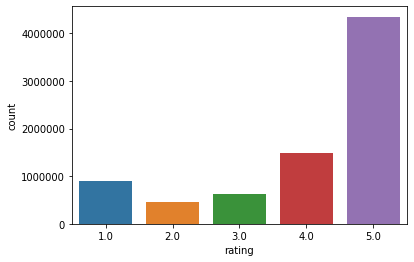

In [10]:
# Let's check distribution of userRatings
sns.countplot(e_commerce_data.rating)

In [11]:
e_commerce_data.groupby('userID')['rating'].count().sort_values(ascending=False)[0:12]
# here, I'm grouped by userID and taken top 50 ratings counts.

userID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
Name: rating, dtype: int64

In [12]:
print(f'Unique userId ids: {e_commerce_data.userID.nunique()}')
print(f'Unique productId ids: {e_commerce_data.productID.nunique()}')

Unique userId ids: 4201696
Unique productId ids: 476001


In [13]:
user_counts = e_commerce_data['userID'].value_counts()

In [14]:
len(user_counts[user_counts>=292])

12

In [15]:
# I am considering 200 ratings counts based on userID
filter_ = user_counts >= 292
filter_ = filter_[filter_].index.tolist()

In [16]:
# taking only those filtered information from original data.
new_e_commerce_data = e_commerce_data[e_commerce_data['userID'].isin(filter_)]

In [17]:
new_e_commerce_data.head()

,userID,productID,rating
2161,A5JLAU2ARJ0BO,1400532655,1.0
5194,A36K2N527TXXJN,9800359788,5.0
5931,ADLVFFE4VBT8,9981719005,3.0
7747,A680RUE1FDO8B,B000001OMI,5.0
8731,A6FIAB28IS79,B00000J05A,3.0


In [18]:
new_e_commerce_data.shape

(4553, 3)

In [19]:
# let's check number of unique firequently visited users
new_e_commerce_data.userID.nunique()

12

In [20]:
# let's check number of unique  products firequently visited by users
new_e_commerce_data.productID.nunique()

3863

# Popularity based Recommender system

In [21]:
# Define a class 'PopularityBasedRecommender'
class PopularityBasedRecommender:
    
    # initialize cunstructor with data.
    def __init__(self,data):
        self.data = data
    
    # Here create top 5 popular recommendations to user.
    def createTopRecommendations(self,no_recommedations=5):
        data_df = self.data.groupby('productID').agg({'userID':'count'}).reset_index()
        data_df.rename(columns={'userID':'userID_count'},inplace=True)
        
        data_df_sort = data_df.sort_values(['userID_count','productID'],ascending=[0,1])
        data_df_sort['rank'] = data_df_sort['userID_count'].rank(ascending=False,method='first')
        print('Bellow are the top {} recommendations:'.format(no_recommedations))
        print(data_df_sort.head(no_recommedations))

In [22]:
# Initialze class here.
PR = PopularityBasedRecommender(new_e_commerce_data)

In [23]:
PR.createTopRecommendations()

Bellow are the top 5 recommendations:
       productID  userID_count  rank
1033  B000JMJWV2             6   1.0
2669  B0053R0WWG             6   2.0
2965  B0079UAT0A             6   3.0
2995  B007OY5V68             6   4.0
3448  B00CZDT30S             6   5.0


In [24]:
# Checking 
popular_items_df = new_e_commerce_data.groupby(['productID'])['rating'].count().sort_values(ascending=False).reset_index()
popular_items_df.head(5)


,productID,rating
0,B0053R0WWG,6
1,B007OY5V68,6
2,B000JMJWV2,6
3,B0079UAT0A,6
4,B00CZDT30S,6


# Collabrative Filtering
### using surprise.BaselineOnly()

In [25]:
# check upper and lower ratings from data.
lower_rating = new_e_commerce_data.rating.min()
upper_rating = new_e_commerce_data.rating.max()
lower_rating,upper_rating

(1.0, 5.0)

In [26]:
# Convert the dataframe into dataset, shwich supports the surprise lib models.
# First define a reader, whcih intakes lower and upper ratings.
reader = Reader(rating_scale=(lower_rating, upper_rating))
df = new_e_commerce_data[['userID', 'productID', 'rating']]
print(df.head())
# Bys using load_from_df load the original data as a dataset with the help of reader.
data_df = Dataset.load_from_df(df, reader)

              userID   productID  rating
2161   A5JLAU2ARJ0BO  1400532655     1.0
5194  A36K2N527TXXJN  9800359788     5.0
5931    ADLVFFE4VBT8  9981719005     3.0
7747   A680RUE1FDO8B  B000001OMI     5.0
8731    A6FIAB28IS79  B00000J05A     3.0


In [27]:
# Devide the dataset into train and test.
train_data,test_data = train_test_split(data_df,test_size=0.15,random_state=42)

In [28]:
len(test_data)

683

In [29]:
# the bellow code is used to check which model peroformase good based rmse using cross validate method,

In [30]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_df, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.935059,0.011111,0.011577
SVD,0.938553,0.267802,0.014670
SVDpp,0.942321,15.606707,0.177145
KNNBaseline,0.957623,0.013226,0.018404
CoClustering,0.985587,0.562873,0.012057
KNNWithZScore,0.985653,0.003507,0.017803
KNNBasic,0.986917,0.000971,0.016070
SlopeOne,0.987777,0.254954,0.085376
KNNWithMeans,0.989137,0.001881,0.017915


In [31]:
# As we can see, in the above dataframe.
# Whcih is sorted based on 'rmse' values.
# bases on this rmse value, I can say 'BaselineOnly' performance is good.
# And, I go head and build model.

In [32]:
model = BaselineOnly()
model.fit(train_data)

Estimating biases using als...


In [33]:
cross_validate(model, data_df,
               measures=['rmse'],
               cv=3, verbose=False,
               n_jobs=-1,
               return_train_measures=True)

{'test_rmse': array([0.9537737 , 0.90134815, 0.95046182]),
 'train_rmse': array([0.83969722, 0.86369646, 0.84064437]),
 'fit_time': (0.015542030334472656,
  0.009999752044677734,
  0.015397787094116211),
 'test_time': (0.013255119323730469,
  0.011644840240478516,
  0.01740574836730957)}

In [34]:
test_pred = model.test(test_data)

In [35]:
test_pred[0:10]

[Prediction(uid='A5JLAU2ARJ0BO', iid='B0002ICEF4', r_ui=5.0, est=3.820989775617595, details={'was_impossible': False}),
 Prediction(uid='A2AY4YUOX2N1BQ', iid='B004UT0T5S', r_ui=5.0, est=4.526997200914659, details={'was_impossible': False}),
 Prediction(uid='A36K2N527TXXJN', iid='B00DK9N154', r_ui=5.0, est=4.506051691145646, details={'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B006OM75I8', r_ui=5.0, est=4.578641147650728, details={'was_impossible': False}),
 Prediction(uid='AWPODHOB4GFWL', iid='B0052OZZYK', r_ui=5.0, est=4.426215755345932, details={'was_impossible': False}),
 Prediction(uid='ADLVFFE4VBT8', iid='B007JIBAZA', r_ui=2.0, est=4.307059762299322, details={'was_impossible': False}),
 Prediction(uid='A2AY4YUOX2N1BQ', iid='B004K1FTII', r_ui=4.0, est=4.526997200914659, details={'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B00HLAGR0E', r_ui=5.0, est=4.578641147650728, details={'was_impossible': False}),
 Prediction(uid='A1ODOGXEYECQQ8', ii

In [36]:
accuracy.rmse(test_pred)

RMSE: 0.9634


0.9633671149116884

In [37]:
model.predict('A23GFTVIETX7DS','B0079TOEQQ')

Prediction(uid='A23GFTVIETX7DS', iid='B0079TOEQQ', r_ui=None, est=4.4378601151587285, details={'was_impossible': False})

### using scipy.sparse.linalg.svds()

#### Preprocessing data

In [38]:
# Prepare pivot dataframe from 'new_e_commerce_data'.
# 'new_e_commerce_data' is a dataframe, where it consists only users who have more than 290 counts.
final_rating_matrix = new_e_commerce_data.pivot(index='userID',columns='productID',values='rating').fillna(0)

In [39]:
# pivot dataframe
final_rating_matrix.head()

productID,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
userID,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,5.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0
A22CW0ZHY3NJH8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0
A25C2M3QF9G7OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
A2AY4YUOX2N1BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A36K2N527TXXJN,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
final_rating_matrix.shape

(12, 3863)

In [41]:
final_df = final_rating_matrix.copy(True)

In [42]:
# Replace index column from 'userID' to 'user_index' numerical type
final_df['user_index'] = np.arange(0,final_df.shape[0],1)
final_df.set_index(['user_index'],inplace=True)

In [43]:
final_df.head()

productID,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,5.0,5.0,0.0,5.0,0.0,3.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### -----------------

In [44]:
from scipy.sparse.linalg import svds

In [45]:
# prepare 'UBCollabrativeFilter' class.
class UBCollabrativeFilter:
    
    def __init__(self,actual_df):
        self.actual_df = actual_df
        
    # To check the sparsity of the matrix
    def checkSparsityOfData(self):
        number_of_nozero_ratings = np.count_nonzero(self.actual_df)
        sparsity = (1 - number_of_nozero_ratings / self.actual_df.size ) * 100
        print('Num of non zero values: {}'.format(number_of_nozero_ratings))
        print('Size of data: {}'.format(self.actual_df.size))
        print('sparsity of the data is: {}%'.format(np.round(sparsity,2)))
    
    # To get the predicated rating for zero-ratings.
    def getPredRatings(self):
        pred_ratings_df = self.__svd_()
        return pred_ratings_df
       
    # Calcualte SVD using actual data.
    def __svd_(self):
        # 'k' value should be between 1 and 'min(actual.shape)'.
        k = min(self.actual_df.shape)
        u,sigma,vt = svds(self.actual_df,k=k-1)
        # Convert single D sigma to diagonal matrix.
        sigma = np.diag(sigma)
        # get dot product of u,sigma and vt.
        pred_ratings_df = self.__dotProductAndPrepareDF(u,sigma,vt)
        return pred_ratings_df
    
    # prepare dataframe from dot product of u, sigma and vt.
    def __dotProductAndPrepareDF(self,u,sigma,vt):
        pred_ratings_df = pd.DataFrame(np.dot(np.dot(u,sigma),vt),columns=self.actual_df.columns)
        return pred_ratings_df
    
    # This method takes userId pred_df and no_recommendation as params.
    # pred_df: is predicted ratings.
    # no_recmmendation: is the count to show recommedations.
    def recommendationUB(self,userId,pred_df,no_recmmendation):
        # Here, reduce user_idx by one.
        user_idx = userId-1
        # get sorted actual ratings from actual df in Descending order.
        sorted_actual_ratings = self.actual_df.iloc[user_idx].sort_values(ascending = False)
        # get sorted pred ratings from pred df in Descending order.
        sorted_pred_ratings = pred_df.iloc[user_idx].sort_values(ascending = False)
        # concat actual and pred sorted ratings.
        concat_df = pd.concat([sorted_actual_ratings,sorted_pred_ratings],axis=1)
        concat_df.index.name = ['productID']
        concat_df.columns = ['user_ratings','predicted_ratings']
        # Filter concat df based on user_rating where 'user_ratings' has '0.0' ratings.
        # Sort the filtered concat df based 'predicted_ratings'  in descending order.
        concat_df = concat_df[concat_df.user_ratings == 0].sort_values('predicted_ratings',ascending = False)
        print(concat_df.head(no_recmmendation))
        mse_score = mean_squared_error(concat_df['user_ratings'],concat_df['predicted_ratings'])
        rmse_score = math.sqrt(mse_score)
        print('RMSE score: {}'.format(np.round(rmse_score,4)))
    

In [46]:
# Initialize the 'UBCollabrativeFilter' class with passing 'final_df'.
ubCollabFilterObj = UBCollabrativeFilter(final_df)

In [47]:
# As we can see the matrix is sparsed.
ubCollabFilterObj.checkSparsityOfData()

Num of non zero values: 4553
Size of data: 46356
sparsity of the data is: 90.18%


In [48]:
# Get the prepdicated ratings by calling the 'getPredRatings()' method.
predicted_ratings = ubCollabFilterObj.getPredRatings()

In [49]:
predicted_ratings.head()

productID,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,...,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
0,-0.000163,-0.077951,0.010418,-0.010422,0.010617,-0.066284,0.017695,0.010617,-0.066284,-0.039203,...,4.780773,0.689313,4.780773,4.780773,0.976444,4.780773,0.959080,2.868464,-0.065491,-0.333982
1,0.000714,0.341023,-0.045578,0.045595,-0.046448,0.289981,-0.077413,-0.046448,0.289981,0.171507,...,0.959080,0.984368,0.959080,0.959080,0.728219,0.959080,0.804182,0.575448,0.286514,1.461117
2,-0.000248,-0.118755,0.015872,-0.015878,0.016175,-0.100981,0.026958,0.016175,-0.100981,-0.059724,...,-0.333982,1.050139,-0.333982,-0.333982,1.487570,-0.333982,1.461117,-0.200389,-0.099773,4.491193
3,-0.000002,-0.000948,0.000127,-0.000127,0.000129,-0.000806,0.000215,0.000129,-0.000806,-0.000477,...,-0.002665,0.008380,-0.002665,-0.002665,0.011871,-0.002665,0.011660,-0.001599,-0.000796,-0.004060
4,-0.000058,4.972283,0.003704,-0.003706,0.003775,-0.023569,0.006292,0.003775,-0.023569,-0.013940,...,-0.077951,5.245101,-0.077951,-0.077951,0.347197,-0.077951,0.341023,-0.046771,-0.023287,-0.118755


In [51]:
# below are the top 5 recommendation for given user.
user_id = 10
no_recommedations = 5
ubCollabFilterObj.recommendationUB(user_id,predicted_ratings,no_recommedations)

             user_ratings  predicted_ratings
[productID]                                 
B00E3FHXYO            0.0           0.056553
B00EDCF0MY            0.0           0.056553
B0061GQ7PO            0.0           0.049950
B00B3YQGHS            0.0           0.047117
B00A1DJO12            0.0           0.044403
RMSE score: 0.0194
